In [1]:
# Cell: Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

In [82]:
df = yf.download("BTC-USD", start="2020-01-01", end="2024-01-01", interval="1d")
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095
...,...,...,...,...,...,...
2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,43442.855469,25260941032
2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014
2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055


In [84]:
# Cell: Load the dataset
# df = pd.read_csv('df_btc.csv', parse_dates=['Datetime'], index_col='Datetime')

# Calculate additional features: Moving Averages and Bollinger Bands
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()

# Bollinger Bands
df['20_day_std'] = df['Close'].rolling(window=20).std()
df['Upper_Band'] = df['MA_20'] + (df['20_day_std'] * 2)
df['Lower_Band'] = df['MA_20'] - (df['20_day_std'] * 2)

# Drop NaN values created by rolling calculations
df.dropna(inplace=True)

# Select features for model input
features = ['Close', 'Volume', 'MA_10', 'MA_20', 'Upper_Band', 'Lower_Band']
dataset = df[features].values
dataset 

array([[8.65764258e+03, 2.64223757e+10, 8.59685220e+03, 8.11897124e+03,
        9.35361271e+03, 6.88432977e+03],
       [8.74589453e+03, 2.40974185e+10, 8.66768789e+03, 8.19625725e+03,
        9.38125073e+03, 7.01126377e+03],
       [8.68087598e+03, 2.26002041e+10, 8.71652607e+03, 8.28102754e+03,
        9.33685103e+03, 7.22520405e+03],
       ...,
       [4.20994023e+04, 2.60000211e+10, 4.32578621e+04, 4.27697848e+04,
        4.45225514e+04, 4.10170181e+04],
       [4.21569023e+04, 1.60139259e+10, 4.31083273e+04, 4.26886449e+04,
        4.43941735e+04, 4.09831164e+04],
       [4.22651875e+04, 1.63974988e+10, 4.29479309e+04, 4.27397127e+04,
        4.43196264e+04, 4.11597990e+04]])

In [33]:
# Cell: Apply MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [34]:
# Cell 4: Split the dataset into training and testing sets
train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

train 

array([[0.05889917, 0.06102129, 0.05202325, 0.03786725, 0.03540717,
        0.05753885],
       [0.06030903, 0.0542947 , 0.05322019, 0.03921849, 0.03585219,
        0.05983729],
       [0.05927033, 0.04996295, 0.05404542, 0.04070059, 0.03513728,
        0.06371118],
       ...,
       [0.58449567, 0.22817432, 0.67661177, 0.7244977 , 0.73253298,
        0.69582182],
       [0.58730797, 0.06577768, 0.6686518 , 0.72015032, 0.73779211,
        0.68090264],
       [0.59014617, 0.04618493, 0.65975276, 0.71580679, 0.74108281,
        0.66820507]])

In [35]:
# Cell 5: Function to create the dataset with look_back
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])  # Predicting the 'Close' price
    return np.array(dataX), np.array(dataY)

# Define look_back period
look_back = 240

# Create the training and testing datasets for the LSTM
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

testX

array([[[0.58870295, 0.0774601 , 0.65217397, 0.70958666, 0.74036375,
         0.65612967],
        [0.603314  , 0.06074723, 0.64380815, 0.7044354 , 0.73774616,
         0.64840329],
        [0.62269616, 0.08149818, 0.63806961, 0.69845997, 0.727693  ,
         0.64733158],
        ...,
        [0.23988618, 0.05761739, 0.24467083, 0.26299764, 0.2635861 ,
         0.26725877],
        [0.23710099, 0.0679392 , 0.24391442, 0.25943891, 0.25471994,
         0.26985801],
        [0.22152967, 0.11015265, 0.24187986, 0.25550654, 0.24812687,
         0.26912708]],

       [[0.603314  , 0.06074723, 0.64380815, 0.7044354 , 0.73774616,
         0.64840329],
        [0.62269616, 0.08149818, 0.63806961, 0.69845997, 0.727693  ,
         0.64733158],
        [0.60100898, 0.1225563 , 0.63153615, 0.69126489, 0.71659772,
         0.64490549],
        ...,
        [0.23710099, 0.0679392 , 0.24391442, 0.25943891, 0.25471994,
         0.26985801],
        [0.22152967, 0.11015265, 0.24187986, 0.25550654, 0.248

In [36]:
# Cell 6: Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))


In [37]:
# Cell 7: Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(25))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [56]:
# Cell 8: Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(trainX, trainY, epochs=1000, batch_size=20, verbose=1, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0065 - val_loss: 0.0029
Epoch 2/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0085 - val_loss: 0.0062
Epoch 3/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0078 - val_loss: 0.0049
Epoch 4/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0078 - val_loss: 0.0206
Epoch 5/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0082 - val_loss: 0.0029
Epoch 6/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0066 - val_loss: 0.0049
Epoch 7/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0064 - val_loss: 0.0116
Epoch 8/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0071 - val_loss: 0.0034
Epoch 9/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0058 - val_loss: 0.0045
Epoch 10/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0067 - val_loss: 0.0024
Epoch 11/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0062 - val_loss: 0.0053
Epoch 12/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 

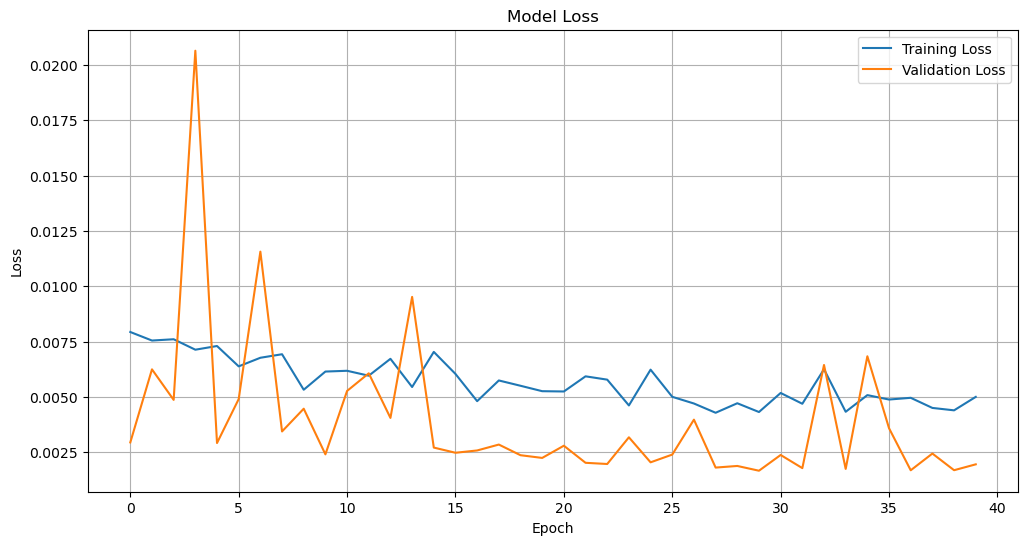

In [57]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [58]:
# Cell 9: Make predictions on the test set
predictions = model.predict(testX)

# Inverse transform to get actual values
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], dataset.shape[1]-1))), axis=1))[:,0]
testY_actual = scaler.inverse_transform(np.concatenate((testY.reshape(-1, 1), np.zeros((testY.shape[0], dataset.shape[1]-1))), axis=1))[:,0]

# Calculate performance metrics
mse = mean_squared_error(testY_actual, predictions)
mae = mean_absolute_error(testY_actual, predictions)
print(f'MSE: {mse}')
print(f'MAE: {mae}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MSE: 3841610.8170262356
MAE: 1749.5128609434446


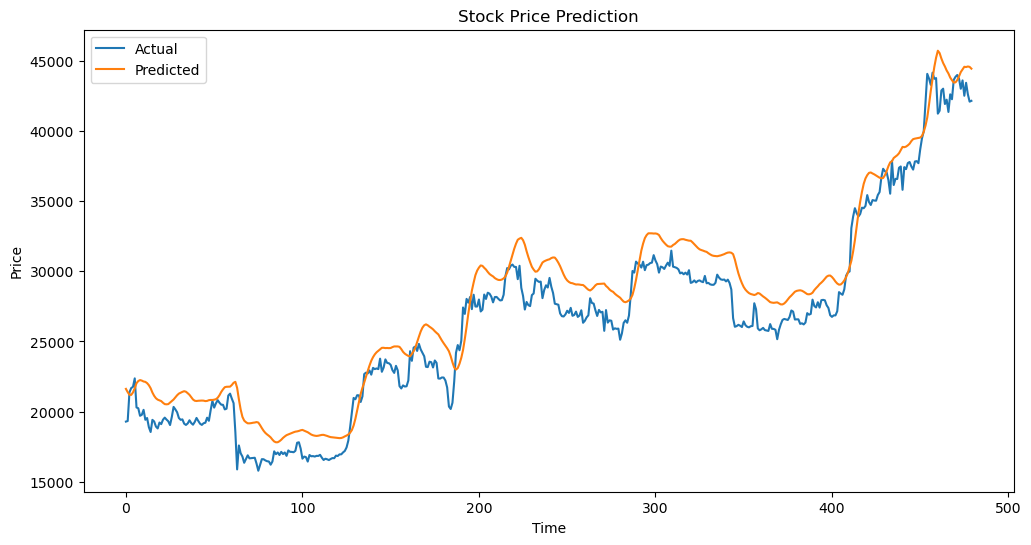

In [59]:
# Cell 10: Plot the predictions against actual values
plt.figure(figsize=(12, 6))
plt.plot(testY_actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()